## Import Necessary Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchvision.models import get_model, get_model_weights, get_weight, list_models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image

from pathlib import Path
from PIL import ImageEnhance
from PIL import Image

import pandas as pd

from IPython.display import Video

import subprocess

from tqdm import tqdm

## Define Hyperparameters

In [14]:
batch_size = 100
learning_rate = 0.001
epochs = 10

## Load Images into PyTorch Dataset and Apply Transforms

In [15]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
])

vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

train_set, validation_set, test_set = random_split(figures_dataset, [0.6, 0.2, 0.2])

dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

gender_dict = {0: "female", 1: "male"}

## Load and Display Reference Images

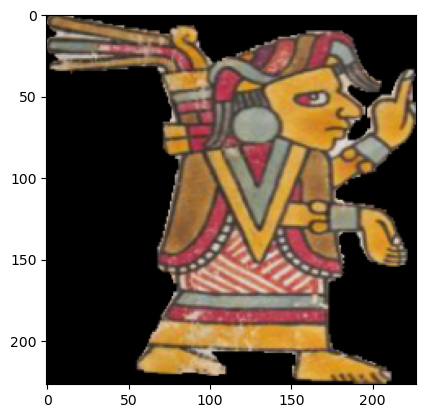

In [16]:
reference_images = ["../data/reference_images/gender/female/003-a-06.png"]

data = [transform(Image.open(ref).convert("RGB")) for ref in reference_images]

data = torch.stack(data)

image = transforms.ToPILImage()(data[0])

plt.imshow(image)

## Define VGG Model and Output Features

In [17]:
class Vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.modules_no = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        self.features = vgg16(pretrained=True).features
        self.features[4]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[9]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[16] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[23] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[30] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        
        self.classifier = vgg16(pretrained=True).classifier
        self.classifier[6] = nn.Linear(4096, 2)
                
        
    def forward(self,x):
        results = {}
        maxpool_indices = {}
        for index, layer in enumerate(self.features):
            if index in [4,9,16,23,30]:
                x,i = layer(x)
                maxpool_indices[index] = i
                
            else:
                x = layer(x)
            
            if index in self.modules_no:
                results[index] = x
                
        x = torch.flatten(x, 1)
        x = self.classifier(x)
                
        return x, results, maxpool_indices
    

## CAM Visualizations

In [55]:
def visualize_feature_maps_in_montage(feature_maps):
    # Convert tensor to numpy
    if isinstance(feature_maps, torch.Tensor):
        feature_maps = feature_maps.detach().cpu().numpy()

    # Extract batch size, number of channels, height and width
    batch_size, num_channels, height, width = feature_maps.shape
    
    # Number of columns and rows for the montage
    num_cols = int(np.sqrt(num_channels))
    num_rows = int(np.ceil(num_channels / num_cols))
    
    # Create a montage image of size (num_rows * height, num_cols * width)
    montage_image = np.zeros((num_rows * height, num_cols * width))

    for i in range(num_channels):
        row = i // num_cols
        col = i % num_cols

        # Normalize the feature map to [0, 1]
        single_map = feature_maps[0, i, :, :]
        single_map = (single_map - single_map.min()) / (single_map.max() - single_map.min())
        
        # Assign feature map to correct location in montage
        montage_image[row * height: (row + 1) * height, col * width: (col + 1) * width] = single_map

    plt.imshow(montage_image, cmap="viridis")
    plt.axis('off')
    plt.show()


## Instantiate Model and Define Working Device

In [19]:
model = Vgg16()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Freeze Initial Low-Level Features, then Unfreeze High-Level Feature Layers

In [20]:
for i in range(0, 19):                
    for param in model.features[i].parameters():
        param.requires_grad = False

# Fine tuning last layers
for i in range(19, 30):
    for param in model.features[i].parameters():
        param.requires_grad = True

## Send Model to GPU

In [21]:
model = model.to(device)

## Definte File Path for Model Saves

In [22]:
savepath = "model_saves/base_model.pth"

## Define Loss Function and Optimizer (Weighted for Pose)

In [ ]:
pose_balance = torch.tensor([1/903, 1/382])
pose_balance = pose_balance.to(device)

criterion = nn.CrossEntropyLoss(weight=pose_balance)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Define Loss Function and Optimizer (Weighted for Gender)

In [23]:
gender_balance = torch.tensor([1/386, 1/899])
gender_balance = gender_balance.to(device)

criterion = nn.CrossEntropyLoss(weight=gender_balance)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train Model and Output Activation Maps for Reference Image

In [24]:
for epoch in tqdm(range(epochs)):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        predictions, activations, max_indices = model(inputs)

        # Get the output from the last layer
        outputs = predictions

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


#     model.eval()

#     data = data.cuda()

#     preds, out, maxpool_ind = model(data)
    
#     class_probability = torch.nn.functional.softmax(preds, dim=1)
    
#     if(class_probability[0][0].item() > class_probability[0][1].item()):
#         predicted_class = gender_dict[0]
#         prediction_strength = round(class_probability[0][0].item(), 2)
        
#     elif(class_probability[0][0].item() < class_probability[0][1].item()):
#         predicted_class = gender_dict[1]
#         prediction_strength = round(class_probability[0][1].item(), 2)

#     ind = 1

#     plt.figure(figsize=[20, 50])

#     ## Calculating average activation in outputs
#     for layer in out:
#         mean = torch.zeros(np.shape(out[layer])[2], np.shape(out[layer])[3])
#         mean = mean.cuda()
#         for i in out[layer][0]:
#             mean += i
#         vis_mean = transforms.ToPILImage()(mean / np.shape(out[layer])[1]) 
#         plot_loc = plt.subplot(5, 3, ind)

#         ind += 1    
#         plt.imshow(vis_mean,cmap='magma')
        
#         plt.title(f'Epoch: {epoch + 1} | {reference_images[0][-12:-4]} | Layer: {layer} | {predicted_class}/{prediction_strength}')
#         plt.colorbar()

        
    
        
#     plt.savefig(f'cam_output/gender/female/003-a-06/{epoch:05d}.png')

#     plt.close()
    
#     model.train()

100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


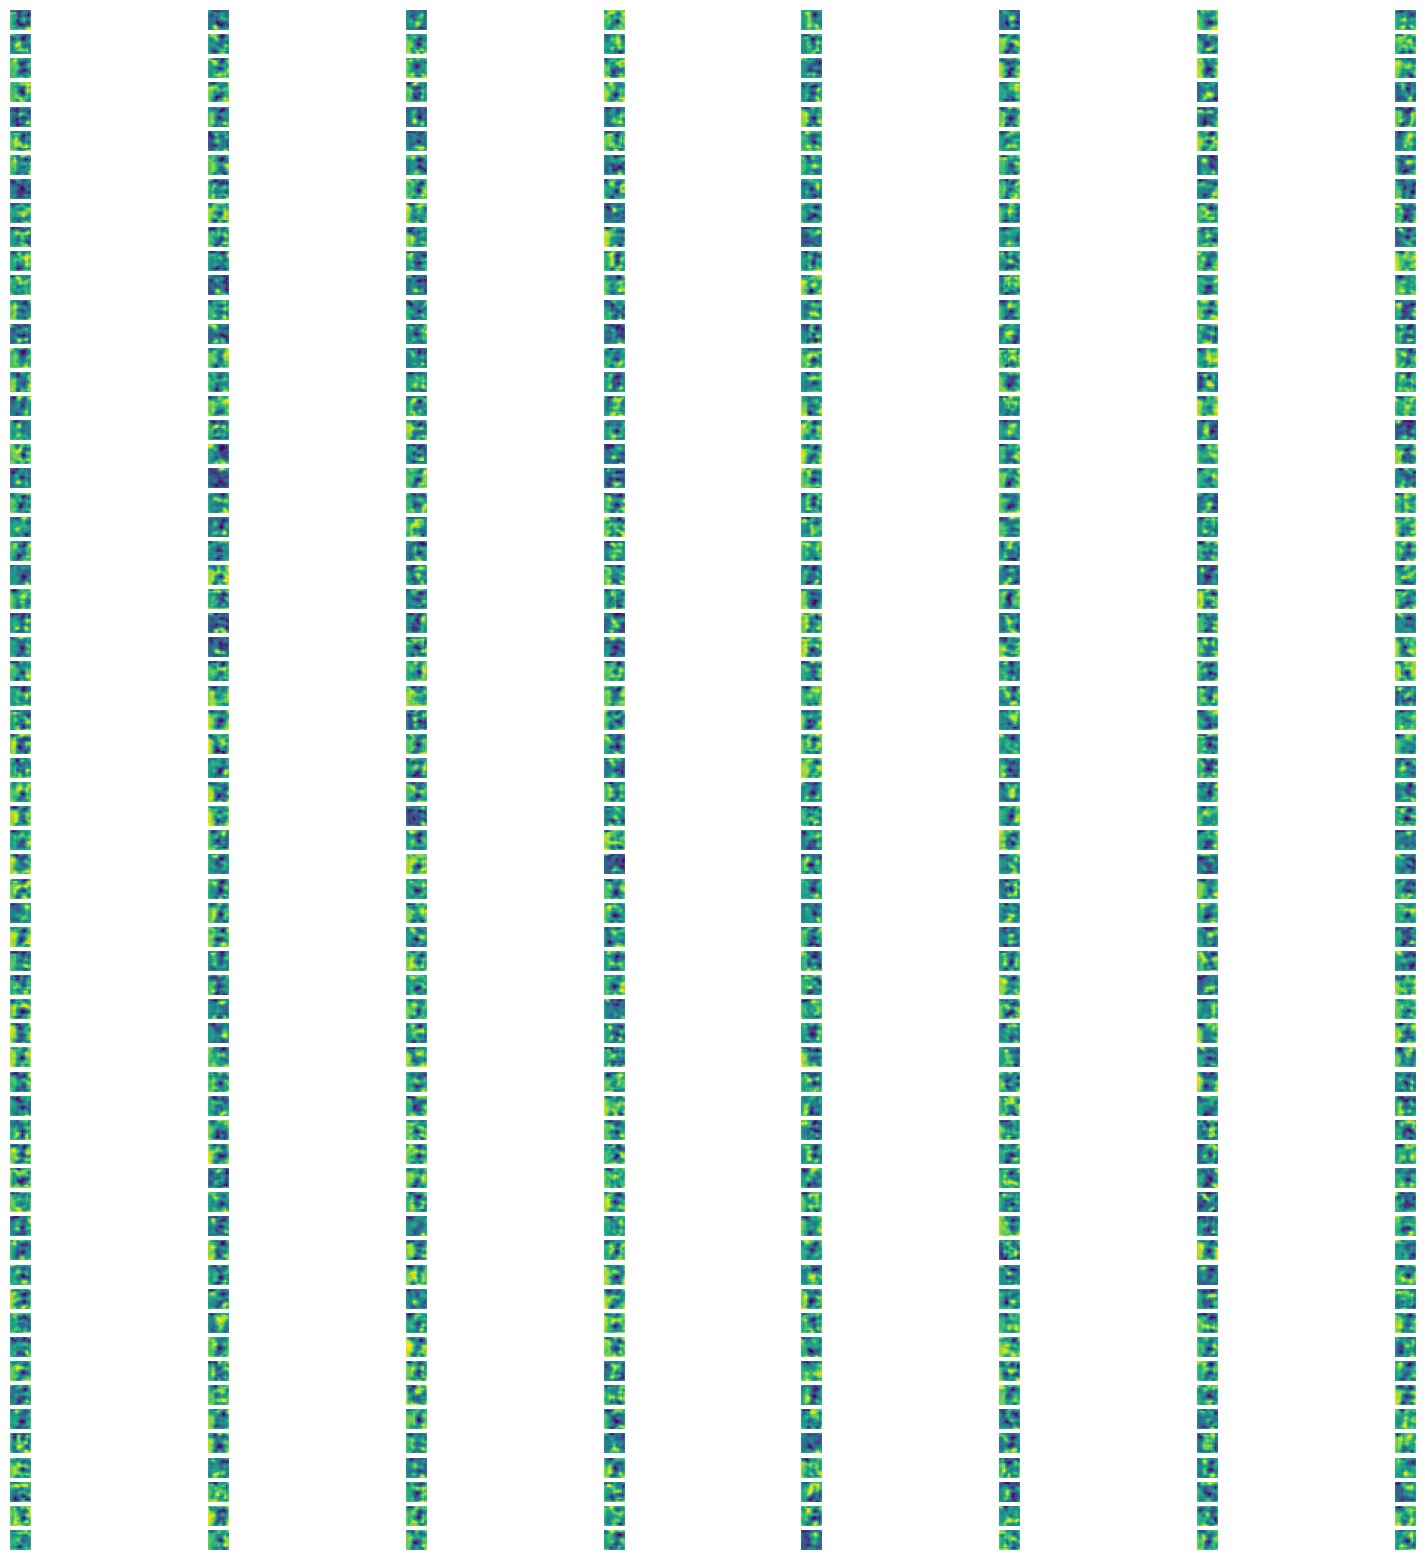

In [54]:
# data = data.cuda()

# visualize_feature_maps(data, model, 28, 28)
model = model.cuda()

visualize_feature_maps_in_montage(data, model, layer_num=28)

In [60]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the target layer to save gradients
        def save_gradients(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.hooks = []
        self.hooks.append(self.target_layer.register_backward_hook(save_gradients))

    def forward(self, x):
        return self.model(x)

    def compute_cam(self, x, class_idx=None):
        # Forward pass
        logits = self.forward(x)
        if class_idx is None:
            class_idx = torch.argmax(logits).item()
        
        # Zero out all other classes and backprop on the selected class
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)

        # Get the pooled gradients and activations
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.target_layer(x)
        for i in range(pooled_gradients.size(0)):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Create the heatmap
        heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach()
        heatmap = F.relu(heatmap)  # ReLU removes negative values
        heatmap /= torch.max(heatmap)

        return heatmap

    
    
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms

# Load your image and preprocess
image_path = '../data/reference_images/gender/female/003-a-06.png'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_img = transform(img).unsqueeze(0)

# Initialize GradCAM and compute the CAM
grad_cam = GradCAM(vgg16.features, vgg16.features[-1])
heatmap = grad_cam.compute_cam(input_img)

# Overlay the heatmap onto the original image
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# Display the original and the Grad-CAM images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img.astype('uint8'))
plt.title('Grad-CAM')
plt.axis('off')
plt.show()


IndexError: index 12888 is out of bounds for dimension 0 with size 512

## Generate Video of Class Activation Maps

In [ ]:
!ffmpeg -framerate 30 -pattern_type glob -pix_fmt yuv420p -i 'cam_output/pose/not_standing/067-a-09/*.png' videos/067-a-09.mp4

## Display Video

In [ ]:
Video("videos/067-a-09.mp4")

## Save Trained Model for Testing

In [ ]:
model.eval()

savepath = "model_saves/trained_model.pth"
torch.save(model.state_dict(), savepath)

# Testing

## Load images and labels from test_loader

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

## Load model

In [ ]:
model = Vgg16()
model.load_state_dict(torch.load(savepath))
model.to(device)

## Calculate Performance of Model (Accuracy, Precision, Recall, & F1)

In [ ]:
model.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

In [ ]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")